<a href="https://colab.research.google.com/github/6370796390/rotten_tomatoes_movies3.ipynb/blob/main/Rotten_Tomatoes_Movies3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas openpyxl

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from google.colab import files
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import io
import joblib

In [82]:
# Step 1: Upload the dataset in Google Colab
print("Please upload the Excel file containing the dataset.")
uploaded = files.upload()

Please upload the Excel file containing the dataset.


Saving Rotten_Tomatoes_Movies3.xls to Rotten_Tomatoes_Movies3 (2).xls


In [83]:
# Load the dataset (assumes the uploaded file is an Excel file)
file_name = list(uploaded.keys())[0]
df = pd.read_excel(uploaded[file_name])  # Correct way to read excel


<ipython-input-83-ab97c54d4fca>:3: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df = pd.read_excel(uploaded[file_name])  # Correct way to read excel


In [84]:
# Display basic information
print("\nDataset Overview:\n")
print(df.head())


Dataset Overview:

                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  A teenager discovers he's the descendant of a ...   
1  Kate has a lot on her mind. There's the ethics...   
2  Blake Edwards' 10 stars Dudley Moore as George...   
3  A Puerto Rican youth is on trial for murder, a...   
4  This 1954 Disney version of Jules Verne's 20,0...   

                                   critics_consensus rating  \
0  Though it may seem like just another Harry Pot...     PG   
1  Nicole Holofcener's newest might seem slight i...      R   
2                                                NaN      R   
3  Sidney Lumet's feature debut is a superbly wri...  

In [80]:
print("\nStatistical Summary:\n")
print(df.describe())


Statistical Summary:

       movie_title   movie_info  critics_consensus       rating        genre  \
count  7610.000000  7610.000000        7610.000000  7610.000000  7610.000000   
mean   3730.776084  3804.500000        3803.213009     4.381997   383.448095   
std    2151.955808  2196.962107        2196.171179     1.684644   172.178180   
min       0.000000     0.000000           0.000000     0.000000     0.000000   
25%    1870.250000  1902.250000        1902.250000     3.000000   228.000000   
50%    3733.500000  3804.500000        3802.500000     4.000000   433.000000   
75%    5600.750000  5706.750000        5704.750000     6.000000   534.000000   
max    7460.000000  7609.000000        7607.000000     7.000000   623.000000   

         directors      writers         cast  in_theaters_date  \
count  7610.000000  7610.000000  7610.000000      7.610000e+03   
mean   1885.911958  3051.995269  3804.500000      1.056381e+18   
std    1058.967794  1740.839823  2196.962107      4.813878

In [77]:
# Check for null values and summary statistics
print("\nMissing Values:\n")
print(df.isnull().sum())


Missing Values:

movie_title                  0
movie_info                   0
critics_consensus            0
rating                       0
genre                        0
directors                    0
writers                      0
cast                         0
in_theaters_date             0
on_streaming_date            0
runtime_in_minutes           0
studio_name                  0
tomatometer_status           0
tomatometer_rating           0
tomatometer_count            0
audience_rating              0
predicted_audience_rating    0
dtype: int64


In [78]:
print("\nStatistical Summary:\n")
print(df.describe())


Statistical Summary:

       movie_title   movie_info  critics_consensus       rating        genre  \
count  7610.000000  7610.000000        7610.000000  7610.000000  7610.000000   
mean   3730.776084  3804.500000        3803.213009     4.381997   383.448095   
std    2151.955808  2196.962107        2196.171179     1.684644   172.178180   
min       0.000000     0.000000           0.000000     0.000000     0.000000   
25%    1870.250000  1902.250000        1902.250000     3.000000   228.000000   
50%    3733.500000  3804.500000        3802.500000     4.000000   433.000000   
75%    5600.750000  5706.750000        5704.750000     6.000000   534.000000   
max    7460.000000  7609.000000        7607.000000     7.000000   623.000000   

         directors      writers         cast  in_theaters_date  \
count  7610.000000  7610.000000  7610.000000      7.610000e+03   
mean   1885.911958  3051.995269  3804.500000      1.056381e+18   
std    1058.967794  1740.839823  2196.962107      4.813878

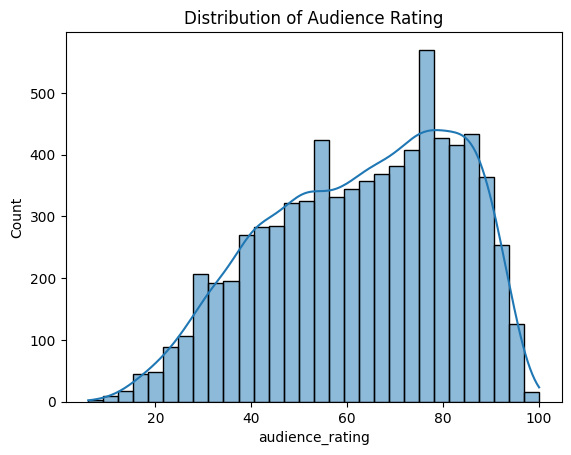

In [ ]:
# Visualize target variable distribution
if 'audience_rating' in df.columns:
    sns.histplot(df['audience_rating'], bins=30, kde=True)
    plt.title('Distribution of Audience Rating')
    plt.show()
else:
    raise ValueError("The target variable 'audience_rating' is not in the dataset.")


In [ ]:
# Step 3: Data Preprocessing
# Handle missing values (e.g., drop or impute)
df = df.dropna()  # Drop rows with missing values

# Convert DateTime columns to numeric features (if any)
datetime_cols = df.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    df[col] = df[col].astype(np.int64)  # Convert to Unix timestamp (numeric format)

# Encode categorical features
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature-target split
X = df.drop(columns=['audience_rating'])
y = df['audience_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 4: Model Selection and Training
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Initialize a dictionary to store evaluation results
evaluation_results = {}

# Evaluate models
print("\nModel Performance:")
for name, model in models.items():
    try:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store the results in the dictionary
        evaluation_results[name] = {
            'MAE': mae,
            'MSE': mse,
            'R2 Score': r2
        }

        # Print the performance of each model
        print(f"{name} Performance:")
        print(f" MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}\n")

    except Exception as e:
        # Handle any errors that occur during fitting or prediction
        print(f"Error with model {name}: {e}")

# Optional: Show evaluation results in a DataFrame for better clarity
evaluation_df = pd.DataFrame(evaluation_results)
print("\nModel Evaluation Summary:")
print(evaluation_df)



Model Performance:
Linear Regression Performance:
 MAE: 15.7800, MSE: 356.6869, R2 Score: 0.0624

Decision Tree Performance:
 MAE: 13.6393, MSE: 312.1321, R2 Score: 0.1795

Random Forest Performance:
 MAE: 9.7016, MSE: 151.8937, R2 Score: 0.6007


Model Evaluation Summary:
          Linear Regression  Decision Tree  Random Forest
MAE               15.779972      13.639290       9.701557
MSE              356.686930     312.132063     151.893662
R2 Score           0.062354       0.179478       0.600707


In [ ]:
# Step 5: Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Random Forest:", grid_search.best_params_)

Best Hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
# Final Model Evaluation
best_rf = grid_search.best_estimator_
y_pred_final = best_rf.predict(X_test)
print("\nFinal Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_final))
print("MSE:", mean_squared_error(y_test, y_pred_final))
print("R2 Score:", r2_score(y_test, y_pred_final))


Final Model Performance:
MAE: 9.652784350309696
MSE: 148.868122561332
R2 Score: 0.6086606890032331


In [ ]:
# Step 6: Pipeline Creation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(**grid_search.best_params_, random_state=42))
])

pipeline.fit(X_train, y_train)
final_predictions = pipeline.predict(X_test)
print("Pipeline R2 Score:", r2_score(y_test, final_predictions))

Pipeline R2 Score: 0.6088263694628949


In [ ]:
# Step 7: Predict 'audience_rating' for the existing data (same dataset)
# Preprocess the same dataset for prediction (using the same preprocessing steps as for training data)
df_preprocessed = df.copy()

In [ ]:
# Step 7.1: Apply the same LabelEncoding for categorical features in the dataset
for col in categorical_cols:
    if col in df_preprocessed.columns:
        # Ensure the label encoder was created during training, then apply the same transformation to the data
        df_preprocessed[col] = label_encoders[col].transform(df_preprocessed[col])

In [ ]:
# Step 7.2: Drop any remaining rows with missing values (if any) from the dataset
df_preprocessed = df_preprocessed.dropna()

In [ ]:
# Step 7.3: Ensure all features in df_preprocessed are numeric
# Check if any column is still object or string type after encoding, which should no longer be the case
print(df_preprocessed.dtypes)

movie_title             int64
movie_info              int64
critics_consensus       int64
rating                  int64
genre                   int64
directors               int64
writers                 int64
cast                    int64
in_theaters_date        int64
on_streaming_date       int64
runtime_in_minutes    float64
studio_name             int64
tomatometer_status      int64
tomatometer_rating      int64
tomatometer_count       int64
audience_rating       float64
dtype: object


In [ ]:
# Step 7.4: Use the trained pipeline to predict 'audience_rating' for the preprocessed dataset
# Remove the target variable from the prediction data
X_preprocessed = df_preprocessed.drop(columns=['audience_rating'])
predictions = pipeline.predict(X_preprocessed)

In [ ]:
# Step 7.5: Add predictions to the original dataframe as a new column
df['predicted_audience_rating'] = predictions

In [ ]:
# Step 7.6: Display predictions for the 'audience_rating' column in the dataset
print("\nPredicted 'audience_rating' for the existing dataset:")
print(df[['audience_rating', 'predicted_audience_rating']].head())


Predicted 'audience_rating' for the existing dataset:
   audience_rating  predicted_audience_rating
0             53.0                  49.593469
1             64.0                  70.530261
3             97.0                  89.793895
4             74.0                  78.749764
5             37.0                  37.392345


In [ ]:
# Step 8: Save the Pipeline for Future Use (Optional, if you want to save the trained pipeline)
pipeline_filename = 'audience_rating_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved as {pipeline_filename}")


Pipeline saved as audience_rating_pipeline.pkl


In [ ]:
# Step 9: Validate Model Accuracy on Test Set (using the original data)
print("\nFinal Model Accuracy Validation (on the test set):")
print("R2 Score on Test Set:", r2_score(y_test, final_predictions))
print("MAE on Test Set:", mean_absolute_error(y_test, final_predictions))
print("MSE on Test Set:", mean_squared_error(y_test, final_predictions))

# Conclusion
print("\nProject Completed Successfully! Use the saved pipeline for future predictions.")


Final Model Accuracy Validation (on the test set):
R2 Score on Test Set: 0.6088263694628949
MAE on Test Set: 9.649790829518777
MSE on Test Set: 148.8050965931201

Project Completed Successfully! Use the saved pipeline for future predictions.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from google.colab import files
import io

# Step 1: Upload the dataset in Google Colab
print("Please upload the Excel file containing the dataset.")
uploaded = files.upload()

# Load the dataset (assumes the uploaded file is an Excel file)
if uploaded:
    file_name = list(uploaded.keys())[0]
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))  # Correct way to read excel
else:
    raise ValueError("No file uploaded.")
# Display basic information
print("\nDataset Overview:\n")
print(df.head())
print("\nDataset Info:\n")
print(df.info())

# Step 2: Exploratory Data Analysis (EDA)
# Check for null values and summary statistics
print("\nMissing Values:\n")
print(df.isnull().sum())
print("\nStatistical Summary:\n")
print(df.describe())

# Visualize target variable distribution
if 'audience_rating' in df.columns:
    sns.histplot(df['audience_rating'], bins=30, kde=True)
    plt.title('Distribution of Audience Rating')
    plt.show()
else:
    raise ValueError("The target variable 'audience_rating' is not in the dataset.")

# Step 3: Data Preprocessing
# Handle missing values (e.g., drop or impute)
df = df.dropna()  # Drop rows with missing values

# Encode categorical features
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature-target split
X = df.drop(columns=['audience_rating'])
y = df['audience_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Selection and Training
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate models
print("\nModel Performance:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Performance:\n MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}\n")

# Step 5: Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Random Forest:", grid_search.best_params_)

# Final Model Evaluation
best_rf = grid_search.best_estimator_
y_pred_final = best_rf.predict(X_test)
print("\nFinal Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_final))
print("MSE:", mean_squared_error(y_test, y_pred_final))
print("R2 Score:", r2_score(y_test, y_pred_final))

# Step 6: Pipeline Creation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(**grid_search.best_params_, random_state=42))
])

pipeline.fit(X_train, y_train)
final_predictions = pipeline.predict(X_test)
print("Pipeline R2 Score:", r2_score(y_test, final_predictions))

# Step 7: Predict audience_rating for new data
print("\nPlease upload a new Excel file with the same feature columns to predict 'audience_rating'.")
new_data_uploaded = files.upload()
if new_data_uploaded:
    new_file_name = list(new_data_uploaded.keys())[0]
    new_df = pd.read_excel(io.BytesIO(new_data_uploaded[new_file_name]))
else:
    raise ValueError("No file uploaded.")

# Preprocess new data
for col in categorical_cols:
    if col in new_df.columns:
        new_df[col] = label_encoders[col].transform(new_df[col])

new_df = new_df.dropna()  # Ensure no missing values in new data
scaled_predictions = pipeline.predict(new_df)

# Display predictions
print("\nPredicted 'audience_rating' for the new data:")
print(scaled_predictions)

# Step 8: Save the Pipeline for Future Use
import joblib
pipeline_filename = 'audience_rating_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved as {pipeline_filename}")

# Step 9: Validate Model Accuracy on Test Set
print("\nFinal Model Accuracy Validation:")
print("R2 Score on Test Set:", r2_score(y_test, final_predictions))
print("MAE on Test Set:", mean_absolute_error(y_test, final_predictions))
print("MSE on Test Set:", mean_squared_error(y_test, final_predictions))

# Conclusion
print("\nProject Completed Successfully! Use the saved pipeline for future predictions.")